# Imports

In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras = tf.keras

# Functions

In [21]:
def plot_series(time,series,format='-',start=0,end=None,label=None):
      """
      Plots a time series
      If the label != None, Sets a legend 
      """
      plt.plot(time[start:end],series[start:end],format,label=label)
      plt.xlabel('Time')
      plt.ylabel('Value')
      if label:
        plt.legend(fontsize=14)
      plt.grid(True)

In [22]:
def trend(time,slope=0):
  return slope * time

In [23]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1/ np .exp(3* season_time))

In [24]:
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [25]:
def white_noise(time,noise_level=1,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [26]:
def window_dataset(series,window_size,batch_size=32,
                   shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1 , shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size +1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1],window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [27]:
def model_forecast(model,series,window_size):
  """
  Turns the series into a tensor
  Then it uses the model to make predictions on it
  returns the predictions
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

# Setting up the data

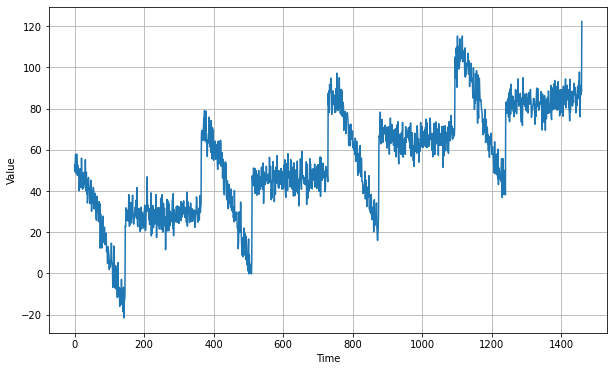

In [28]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [29]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# RNN forecasting 

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train,window_size,batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-7 * 10 **(epoch /20))

optimizer = keras.optimizers.SGD(lr=1e-7,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 46ms/step - loss: 56.7843 - mae: 57.2842
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 20.7913 - mae: 21.2817
Epoch 3/100
8/8 [==============================] - 0s 50ms/step - loss: 21.4339 - mae: 21.9282
Epoch 4/100
8/8 [==============================] - 0s 42ms/step - loss: 17.3767 - mae: 17.8684
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 15.5281 - mae: 16.0178
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 14.7527 - mae: 15.2405
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 15.4067 - mae: 15.8935
Epoch 8/100
8/8 [==============================] - 0s 45ms/step - loss: 15.3333 - mae: 15.8238
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 14.1437 - mae: 14.6292
Epoch 10/100
8/8 [==============================] - 0s 40ms/step - loss: 13.8240 - mae: 14.3111
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

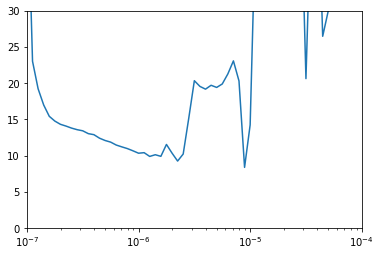

In [32]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [35]:
%%time

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size,batch_size=128)
valid_set = window_dataset(x_valid,window_size,batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=1.5e-6,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=30)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_check_point",sabe_best_only=True)

model.fit(train_set,
          epochs=500,
          validation_data = valid_set,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 98ms/step - loss: 62.2651 - mae: 62.7634 - val_loss: 53.7722 - val_mae: 54.2722
INFO:tensorflow:Assets written to: my_check_point/assets
Epoch 2/500
8/8 [==============================] - 0s 51ms/step - loss: 36.4882 - mae: 36.9857 - val_loss: 17.5197 - val_mae: 18.0159
INFO:tensorflow:Assets written to: my_check_point/assets
Epoch 3/500
8/8 [==============================] - 0s 49ms/step - loss: 22.5146 - mae: 23.0087 - val_loss: 18.8162 - val_mae: 19.3131
INFO:tensorflow:Assets written to: my_check_point/assets
Epoch 4/500
8/8 [==============================] - 0s 58ms/step - loss: 16.8478 - mae: 17.3388 - val_loss: 20.0788 - val_mae: 20.5775
INFO:tensorflow:Assets written to: my_check_point/assets
Epoch 5/500
8/8 [==============================] - 0s 50ms/step - loss: 13.6259 - mae: 14.1149 - val_loss: 6.8458 - val_mae: 7.3288
INFO:tensorflow:Assets written to: my_check_point/assets
Epoch 6/500
8/8 [==============================

In [36]:
model = keras.models.load_model('my_check_point')

In [39]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:,0]

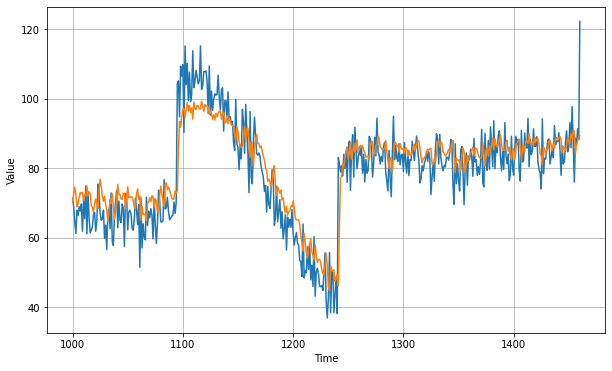

In [40]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

# Sequence to Sequence Forecasting

In [41]:
def seq2seq_window_dataset(series,window_size,batch_size=32,
                           shuffle_buffer=1000):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [42]:
for X_batch,Y_batch in seq2seq_window_dataset(tf.range(10),3,batch_size=1):

  print("X: ",X_batch.numpy())
  print("Y: ",Y_batch.numpy())

X:  [[[1]
  [2]
  [3]]]
Y:  [[[2]
  [3]
  [4]]]
X:  [[[2]
  [3]
  [4]]]
Y:  [[[3]
  [4]
  [5]]]
X:  [[[4]
  [5]
  [6]]]
Y:  [[[5]
  [6]
  [7]]]
X:  [[[3]
  [4]
  [5]]]
Y:  [[[4]
  [5]
  [6]]]
X:  [[[5]
  [6]
  [7]]]
Y:  [[[6]
  [7]
  [8]]]
X:  [[[6]
  [7]
  [8]]]
Y:  [[[7]
  [8]
  [9]]]
X:  [[[0]
  [1]
  [2]]]
Y:  [[[1]
  [2]
  [3]]]


In [44]:
%%time 

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30 
train_set = seq2seq_window_dataset(x_train,window_size,batch_size=128)

mode = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-7 * 10 **(epoch/30))

optimizer = keras.optimizers.SGD(lr=1e-7,momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

history = model.fit(train_set , epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 37ms/step - loss: 8.6862 - mae: 9.1683
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 8.4212 - mae: 8.9033
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 8.3199 - mae: 8.8006
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 8.0519 - mae: 8.5318
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 8.1548 - mae: 8.6345
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 7.8402 - mae: 8.3205
Epoch 7/100
8/8 [==============================] - 0s 37ms/step - loss: 8.6345 - mae: 9.1146
Epoch 8/100
8/8 [==============================] - 0s 42ms/step - loss: 8.1135 - mae: 8.5940
Epoch 9/100
8/8 [==============================] - 0s 49ms/step - loss: 8.0657 - mae: 8.5461
Epoch 10/100
8/8 [==============================] - 0s 40ms/step - loss: 7.9895 - mae: 8.4695
Epoch 11/100
8/8 [==============================] - 0s 40ms/step - lo

(1e-07, 0.0001, 0.0, 30.0)

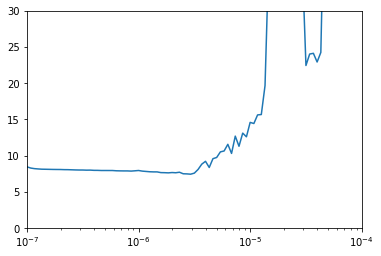

In [45]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [46]:
%%time 

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train,window_size,
                                   batch_size=128)

valid_set = seq2seq_window_dataset(x_valid,window_size,
                                   batch_size = 128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=12)

model.fit(train_set,epochs=500,
          validation_data = valid_set,
          callbacks=[early_stopping])


Epoch 1/500
8/8 [==============================] - 2s 87ms/step - loss: 61.3631 - mae: 61.8618 - val_loss: 17.9208 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 0s 56ms/step - loss: 35.1588 - mae: 35.6565 - val_loss: 20.5483 - val_mae: 21.0442
Epoch 3/500
8/8 [==============================] - 1s 57ms/step - loss: 29.5357 - mae: 30.0314 - val_loss: 37.8714 - val_mae: 38.3709
Epoch 4/500
8/8 [==============================] - 1s 60ms/step - loss: 21.7890 - mae: 22.2826 - val_loss: 25.2686 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 0s 53ms/step - loss: 17.9243 - mae: 18.4150 - val_loss: 15.3557 - val_mae: 15.8506
Epoch 6/500
8/8 [==============================] - 0s 53ms/step - loss: 14.9311 - mae: 15.4179 - val_loss: 9.4218 - val_mae: 9.9071
Epoch 7/500
8/8 [==============================] - 0s 54ms/step - loss: 14.3013 - mae: 14.7875 - val_loss: 9.1617 - val_mae: 9.6474
Epoch 8/500
8/8 [==============================] - 0s 50ms/step - 

In [49]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

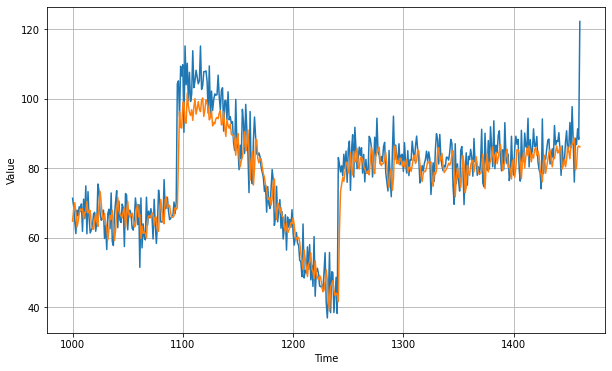

In [50]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [51]:
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

5.37268